# Loading
 I deleted some duplicates, some very useless rows where the title is like 'advertisemnet' and there is neither editor or author and sometimes no publisher, and I combined editor and author after establishing that there is no overlap between them - Nov 19 1.01 CET

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import Input, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TextVectorization, Embedding
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import L1, L2, L1L2
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
# Importing necessary libraries from sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression





In [ ]:
import json
datapath= '/content/drive/MyDrive/Colab Notebooks/ml_assign/train.json'
with open(datapath, 'r') as f:
  data = json.load(f)

# Data Exploration

In [ ]:
df = pd.DataFrame(data)
df['year'] = df['year'].apply(int)

In [ ]:
df.head()

,ENTRYTYPE,title,editor,year,publisher,author,abstract
0,inproceedings,Philippine Language Resources: Trends and Dire...,None,2009,Association for Computational Linguistics,"[Roxas, Rachel Edita, Cheng, Charibeth, Lim, N...",None
1,inproceedings,A System for Translating Locative Prepositions...,None,1991,Association for Computational Linguistics,"[Japkowicz, Nathalie, Wiebe, Janyce M.]",None
2,inproceedings,Introduction to the Shared Task on Comparing S...,None,2008,College Publications,"[Bos, Johan]",None
3,inproceedings,Pynini: A Python library for weighted finite-s...,None,2016,Association for Computational Linguistics,"[Gorman, Kyle]",None
4,inproceedings,Improving Readability of Swedish Electronic He...,None,2014,Association for Computational Linguistics,"[Grigonyte, Gintarė, Kvist, Maria, Velupillai,...",None


In [ ]:
df.shape

(65914, 7)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65914 entries, 0 to 65913
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ENTRYTYPE  65914 non-null  object
 1   title      65914 non-null  object
 2   editor     1476 non-null   object
 3   year       65914 non-null  int64 
 4   publisher  57713 non-null  object
 5   author     63515 non-null  object
 6   abstract   32383 non-null  object
dtypes: int64(1), object(6)
memory usage: 3.5+ MB


## Missing value exploration

In [ ]:
df.isnull().sum() # missing value

ENTRYTYPE        0
title            0
editor       64438
year             0
publisher     8201
author        2399
abstract     33531
dtype: int64

In [ ]:

df_set_by_year = df.copy().sort_values(by = 'year').set_index('year')

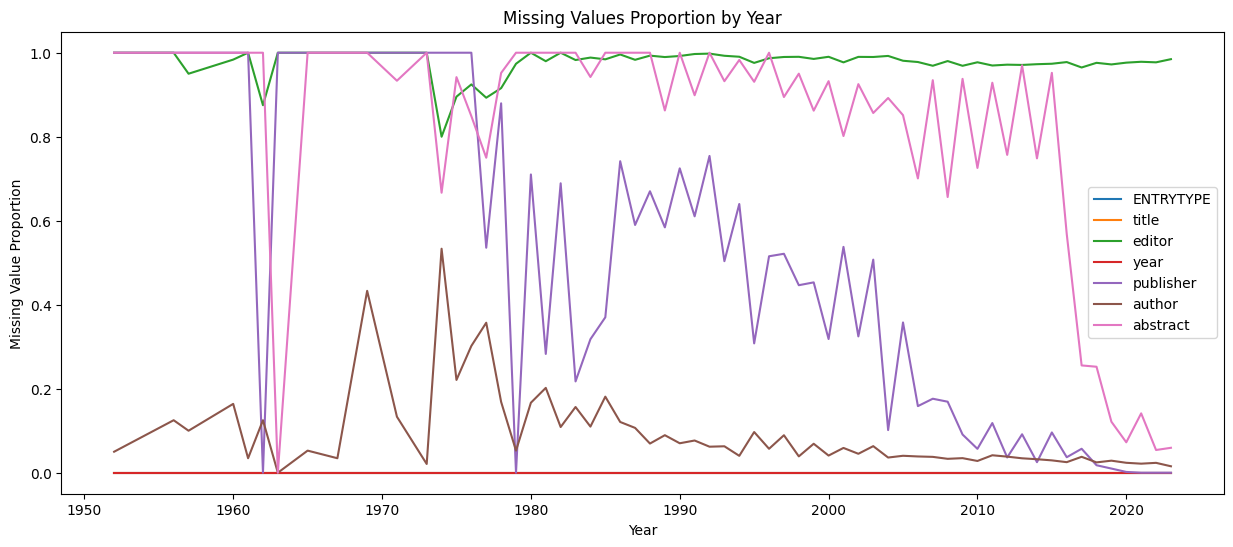

In [ ]:

missing_per_year = df.groupby('year').apply(lambda x: x.isnull().mean())

import matplotlib.pyplot as plt
plt.figure(figsize=(15, 6))
for column in missing_per_year.columns:
    plt.plot(missing_per_year.index, missing_per_year[column], label=column)
plt.xlabel('Year')
plt.ylabel('Missing Value Proportion')
plt.title('Missing Values Proportion by Year')
plt.legend()
plt.show()


In [ ]:

# It can be seen that there is no article with both editors and authors!
print(f'Number of articles with both editors and authors: {df[df["editor"].notnull() & df["author"].notnull()].shape[0]}')
author_only_count = df[df['author'].notnull() & df['editor'].isnull()].shape[0]
print(f'Number of articles with authors only: {author_only_count}')
editor_only_count = df[df['editor'].notnull() & df['author'].isnull()].shape[0]
print(f'Number of articles with editors only: {editor_only_count}')
neither_count = df[df['editor'].isnull() & df['author'].isnull()].shape[0]
print(f'Number of articles with neither editors nor authors: {neither_count}')


Number of articles with both editors and authors: 0
Number of articles with authors only: 63515
Number of articles with editors only: 1476
Number of articles with neither editors nor authors: 923


In [ ]:
# Extract editor and author number as new features
df['no_of_editors'] = df.copy()['editor'].fillna(value= '').apply(len)
df['s'] = df.copy()['author'].fillna(value= '').apply(len)

In [ ]:
# combine editors and authors into one feature
df['edit_author'] = df['editor']

In [ ]:
df['edit_author'].fillna(df['author'], inplace= True)

In [ ]:
df.drop(['editor', 'author'], axis = 1, inplace= True)

In [ ]:
df_set_by_year = df.copy().sort_values(by = 'year').set_index('year')

<Axes: ylabel='year'>

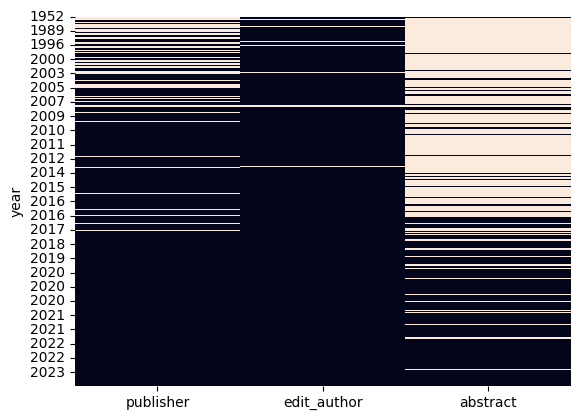

In [ ]:
sns.heatmap(df_set_by_year.loc[:,['publisher', 'edit_author', 'abstract']].isnull(), cbar=False)

## Duplication problem

In [ ]:
dups = df.copy().drop(['edit_author'], axis = 1).duplicated()
df[dups] # duplication problem, 181 duplicates

,ENTRYTYPE,title,year,publisher,abstract,no_of_editors,s,edit_author
3104,article,Publications Received,2006,None,None,0,0,None
7358,article,Advertisements,1988,None,None,0,0,None
8836,article,Briefly Noted,1995,MIT Press,None,0,0,None
9088,article,Errata,2006,None,None,0,0,None
9798,inproceedings,A Flexible Pragmatics-Driven Language Generato...,2003,Association for Computational Linguistics,None,0,1,"[Piwek, Paul]"
...,...,...,...,...,...,...,...,...
65414,inproceedings,CodeSwitch-Reddit: Exploration of Written Mult...,2019,Association for Computational Linguistics,In contrast to many decades of research on ora...,0,3,"[Rabinovich, Ella, Sultani, Masih, Stevenson, ..."
65454,proceedings,International Conference on Computational Ling...,1969,None,None,0,0,None
65606,inproceedings,Analysis and Symbolic Processing of Unrestrict...,1989,None,None,0,2,"[Withgott, M. Margaret, Kaplan, Ronald M.]"
65852,article,Abstracts of Current Literature,1988,None,None,0,0,None


In [ ]:
df[df['title'] == df.iloc[9798, 1]] # print any duplicated rows

,ENTRYTYPE,title,year,publisher,abstract,no_of_editors,s,edit_author
5705,inproceedings,A Flexible Pragmatics-Driven Language Generato...,2003,Association for Computational Linguistics,None,0,1,"[Piwek, Paul]"
9798,inproceedings,A Flexible Pragmatics-Driven Language Generato...,2003,Association for Computational Linguistics,None,0,1,"[Piwek, Paul]"


Advertisements                                                       29
Briefly Noted                                                        20
Abstracts of Current Literature                                      14
Publications Received                                                13
Books Received                                                       13
Author Index                                                         10
Announcements                                                         8
Introduction                                                          5
Summation by Chairman                                                 4
Panel 1: Practical Experience in the Application of MT-Systems        3
Guidelines for Submissions                                            3
personal notes                                                        3
International Conference on Computational Linguistics COLING 1969     2
The FINITE STRING Newsletter: Calendar of Meetings              

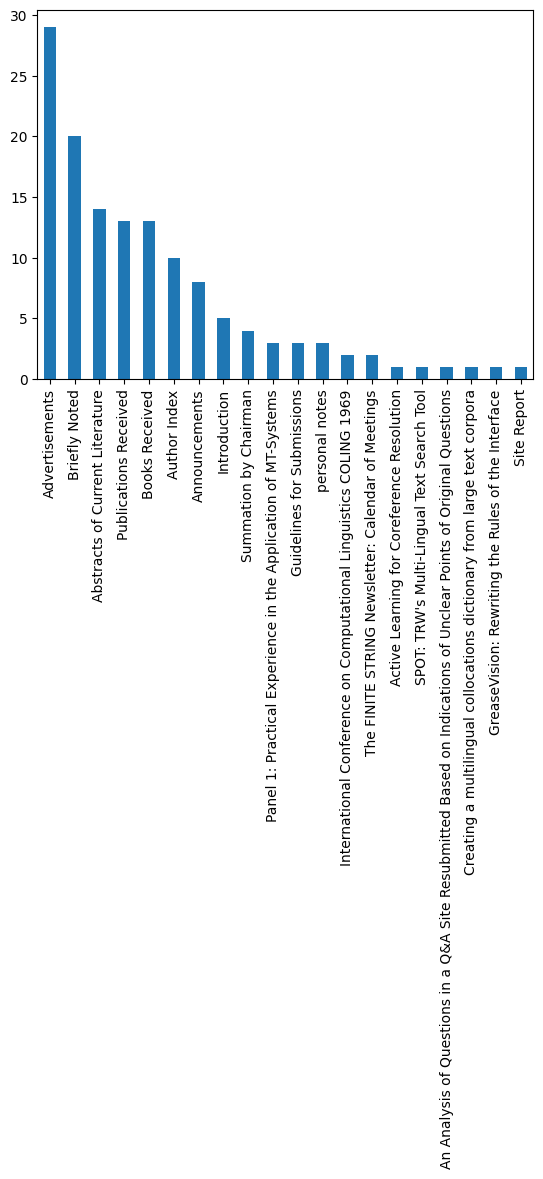

In [ ]:
print(df[dups].iloc[:, 1].value_counts().head(15))
df[dups].iloc[:, 1].value_counts().head(20).plot.bar()
plt.show() # What are those duplicates called?

In [ ]:
import pandas as pd

# 假设 df 是您的原始 DataFrame
# 设置您的阈值
threshold_length = 31  # 例如，50个字符

# 计算 'title' 列的长度
df['title_length'] = df['title'].str.strip().str.len()

# 筛选出长度超过阈值的行，并删除这些行中的重复项
filtered_duplicates = df[df['title_length'] > threshold_length].drop_duplicates(subset='title', keep='first')

# 将处理后的数据与原始数据集中未被选中的部分合并
df = pd.concat([df[df['title_length'] <= threshold_length], filtered_duplicates])

# 如果不再需要 'title_length' 列，可以将其删除
df = df.drop(columns=['title_length'])



<ipython-input-57-0109c1660aa4>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[dups].iloc[:, 1].value_counts().head(15))
<ipython-input-57-0109c1660aa4>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[dups].iloc[:, 1].value_counts().head(20).plot.bar()


Advertisements                     29
Briefly Noted                      20
Abstracts of Current Literature    14
Publications Received              13
Books Received                     13
Author Index                       10
Announcements                       8
Introduction                        5
Summation by Chairman               4
Guidelines for Submissions          3
personal notes                      3
Commentary on Bird and Klein        1
Concluding Remarks                  1
Letter to the Editor                1
Site Report                         1
Name: title, dtype: int64


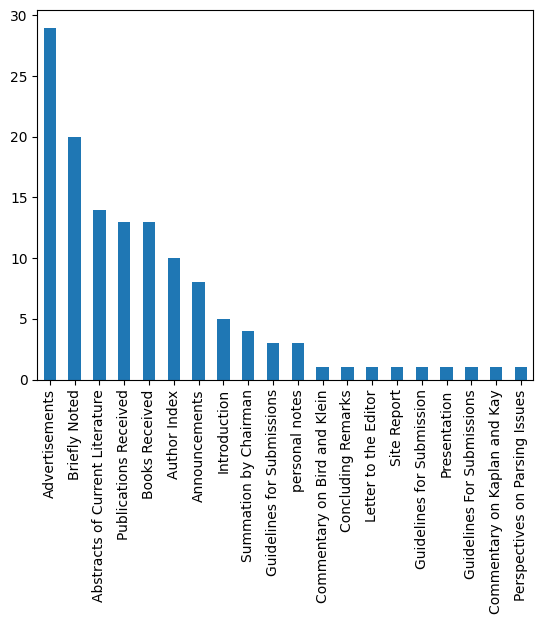

In [ ]:
print(df[dups].iloc[:, 1].value_counts().head(15))
df[dups].iloc[:, 1].value_counts().head(20).plot.bar()
plt.show() # What are those duplicates called?

Among the substantial duplicates, we see many vague duplicates like Advertisements. Should we delete them?

## Explore entry type

In [ ]:
# Explore entrytype
df.iloc[:, 0].unique()

array(['inproceedings', 'article', 'proceedings'], dtype=object)

In [ ]:
df.iloc[:, 0].value_counts()

inproceedings    61687
article           2053
proceedings       1864
Name: ENTRYTYPE, dtype: int64

In [ ]:
df.groupby('ENTRYTYPE').describe()

year                                                  \
                 count         mean        std     min     25%     50%   
ENTRYTYPE                                                                
article         2053.0  2003.443741  14.634080  1974.0  1991.0  2006.0   
inproceedings  61687.0  2012.950703   9.790566  1952.0  2009.0  2016.0   
proceedings     1864.0  2010.299356  12.198065  1956.0  2006.0  2014.0   

                              no_of_editors            ...             \
                  75%     max         count      mean  ...  75%   max   
ENTRYTYPE                                              ...              
article        2017.0  2023.0        2053.0  0.004384  ...  0.0   2.0   
inproceedings  2020.0  2023.0       61687.0  0.000016  ...  0.0   1.0   
proceedings    2019.0  2023.0        1864.0  2.931330  ...  4.0  22.0   

                     s                                                
                 count      mean       std  min  25%  50%  75%   max  
ENTRYTYPE                                                             
article         2053.0  2.109109  2.735725  0.0  1.0  2.0  3.0  61.0  
inproceedings  61687.0  3.324914  2.217602  0.0  2.0  3.0  4.0  77.0  
proceedings     1864.0  0.000000  0.000000  0.0  0.0  0.0  0.0   0.0  

[3 rows x 24 columns]

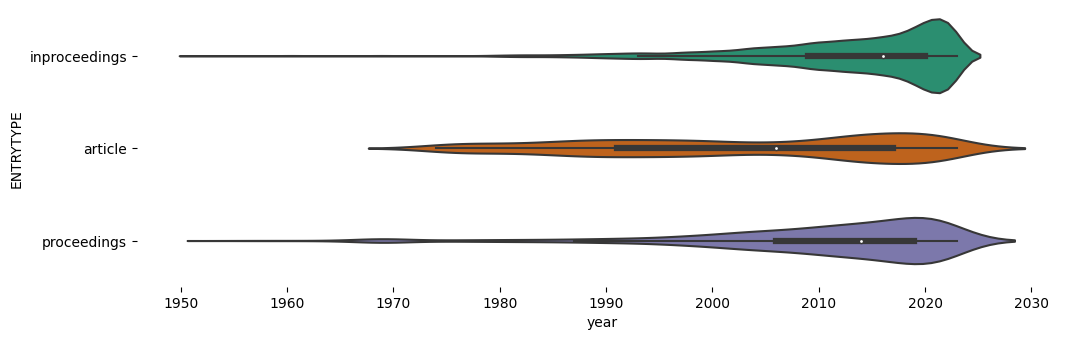

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df['ENTRYTYPE'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='year', y='ENTRYTYPE', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)
# 'Article' type indicates earlier time. Needs to be preserved.

In [ ]:

for i, index in enumerate(df.iloc[:, 0].value_counts().index):
  print(f'The missing value percentage of section {index}')
  print('')
  print((df.loc[df['ENTRYTYPE'] == index, :].isnull().sum()/df.iloc[:, 0].value_counts()[i]) * 100)



The missing value percentage of section inproceedings

ENTRYTYPE         0.000000
title             0.000000
year              0.000000
publisher        11.318430
abstract         48.530485
no_of_editors     0.000000
s                 0.000000
edit_author       0.257753
dtype: float64
The missing value percentage of section article

ENTRYTYPE         0.000000
title             0.000000
year              0.000000
publisher        35.460302
abstract         70.579640
no_of_editors     0.000000
s                 0.000000
edit_author      16.755967
dtype: float64
The missing value percentage of section proceedings

ENTRYTYPE          0.000000
title              0.000000
year               0.000000
publisher         18.025751
abstract         100.000000
no_of_editors      0.000000
s                  0.000000
edit_author       21.673820
dtype: float64


In the Inproceedings section, almost no editor is available, and half of the abstracts are missing. Some publishers, 11% are missing.

The Article section has almost no editors either. There is even more significant missing data in ‘publisher’, ‘author’, and ‘abstract’.

The Proceedings section, however, lacks a fifth of data in ‘editor’ and ‘publisher’, with ‘author’ and ‘abstract’ having no data at all.

<Axes: ylabel='year'>

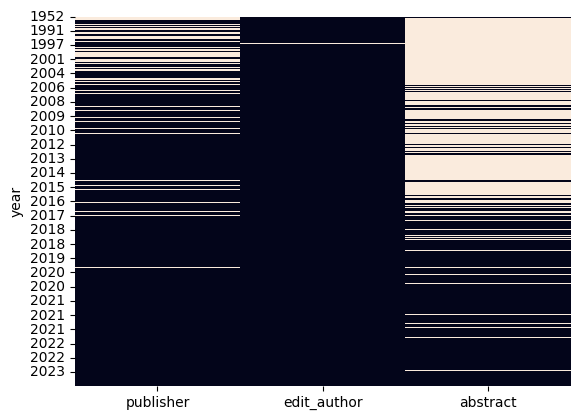

In [ ]:
sns.heatmap(df_set_by_year.loc[df_set_by_year['ENTRYTYPE'] == 'inproceedings',[  'publisher', 'edit_author', 'abstract']].isnull(), cbar=False)

<Axes: ylabel='year'>

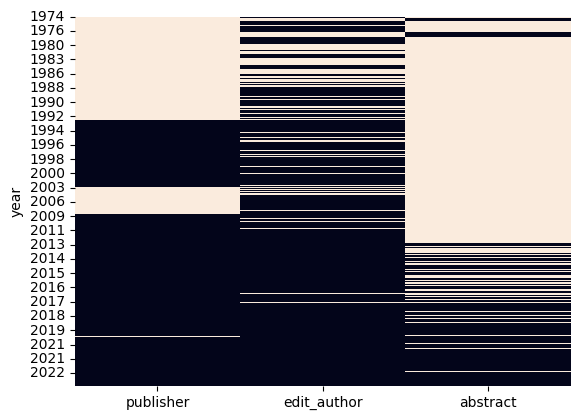

In [ ]:
sns.heatmap(df_set_by_year.loc[df_set_by_year['ENTRYTYPE'] == 'article',[  'publisher', 'edit_author', 'abstract']].isnull(), cbar=False)

<Axes: ylabel='year'>

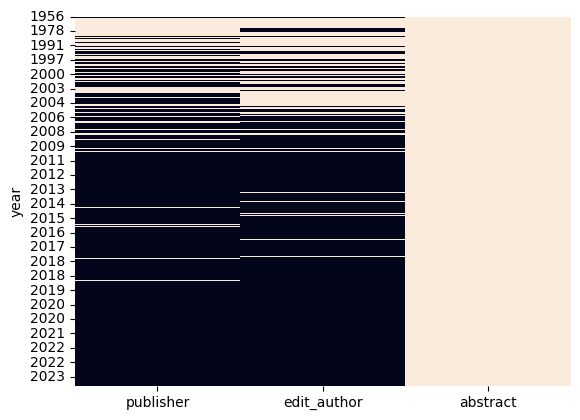

In [ ]:
sns.heatmap(df_set_by_year.loc[df_set_by_year['ENTRYTYPE'] == 'proceedings',[  'publisher', 'edit_author', 'abstract']].isnull(), cbar=False)

## Explore titles

In [ ]:
df['extracted_year'] = df['title'].str.extract(r'.*((19|20)\d{2})').iloc[:, 0].fillna(0).apply(int)
df['first_extracted_year'] = df['title'].str.extract(r'((19|20)\d{2})').iloc[:, 0].fillna(0).apply(int)


In [ ]:
titles_with_years = df[df.copy()['title'].str.contains(r'.*((19|20)\d{2})')]

<ipython-input-67-d8a956e318b1>:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  titles_with_years = df[df.copy()['title'].str.contains(r'.*((19|20)\d{2})')]


In [ ]:
titles_without_years = df[~df.copy()['title'].str.contains(r'.*((19|20)\d{2})')]

<ipython-input-68-75655e5f8ae4>:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  titles_without_years = df[~df.copy()['title'].str.contains(r'.*((19|20)\d{2})')]


In [ ]:
titles_with_years

,ENTRYTYPE,title,year,publisher,abstract,no_of_editors,s,edit_author,extracted_year,first_extracted_year
135,inproceedings,PJAIT Systems for the WMT 2016,2016,Association for Computational Linguistics,None,0,2,"[Wolk, Krzysztof, Marasek, Krzysztof]",2016,2016
1471,article,1984 ACL Membership List,1985,None,None,0,0,None,1984,1984
1474,inproceedings,RDoC Task at BioNLP-OST 2019,2019,Association for Computational Linguistics,BioNLP Open Shared Tasks (BioNLP-OST) is an in...,0,4,"[Anani, Mohammad, Kazi, Nazmul, Kuntz, Matthew...",2019,2019
2658,article,Minutes of the 1985 ACL Meeting,1985,None,None,0,0,None,1985,1985
3118,inproceedings,The InproTK 2012 release,2012,Association for Computational Linguistics,None,0,2,"[Baumann, Timo, Schlangen, David]",2012,2012
...,...,...,...,...,...,...,...,...,...,...
65880,inproceedings,Research methods and system designs in machine...,1994,None,None,0,1,"[Hutchins, John]",1994,1984
65884,proceedings,Proceedings of the NAACL HLT 2009 Workshop on ...,2009,Association for Computational Linguistics,None,3,0,"[Ringger, Eric, Haertel, Robbie, Tomanek, Katrin]",2009,2009
65893,inproceedings,AppTek's Submission to the IWSLT 2022 Isometri...,2022,Association for Computational Linguistics,To participate in the Isometric Spoken Languag...,0,2,"[Wilken, Patrick, Matusov, Evgeny]",2022,2022
65900,inproceedings,The SLT-Interactions Parsing System at the CoN...,2018,Association for Computational Linguistics,This paper describes our system (SLT-Interacti...,0,3,"[Bhat, Riyaz A., Bhat, Irshad, Bangalore, Srin...",2018,2018


In [ ]:
titles_with_years = length_extractor(titles_with_years)

<ipython-input-37-65145db1da6e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['abstract_length'] = df['abstract'].fillna('').str.strip().apply(punctuation).str.split().apply(len)
<ipython-input-37-65145db1da6e>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['title_length'] = df['title'].str.strip().apply(punctuation).str.split().apply(len)


Advertisements                     45
Briefly Noted                      39
Publications Received              32
Author Index                       30
Books Received                     24
Abstracts of Current Literature    23
Introduction                       14
Announcements                      14
Préface [Foreword]                  5
Guidelines for Submissions          5
Natural Language Research           5
Summation by Chairman               5
Letter to the Editor                5
Author and Subject Index            4
Book Reviews                        4
Name: title, dtype: int64


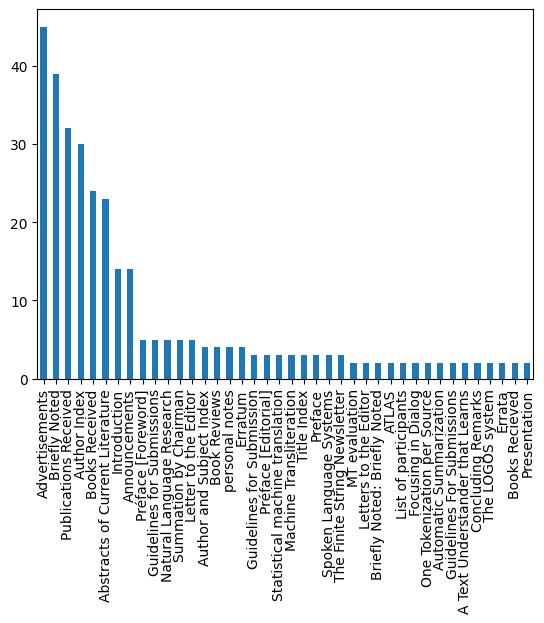

In [ ]:
# Explore title
print(df.iloc[:, 1].value_counts().head(15))
df.iloc[:, 1].value_counts().head(40).plot.bar()
plt.show()

We can see that among 45 Advertisements, 29 are duplicates! Among 39 Breifly Notes 20 are duplicates.

In [ ]:
# top10indices = df.iloc[:, 1].value_counts().index[:10]


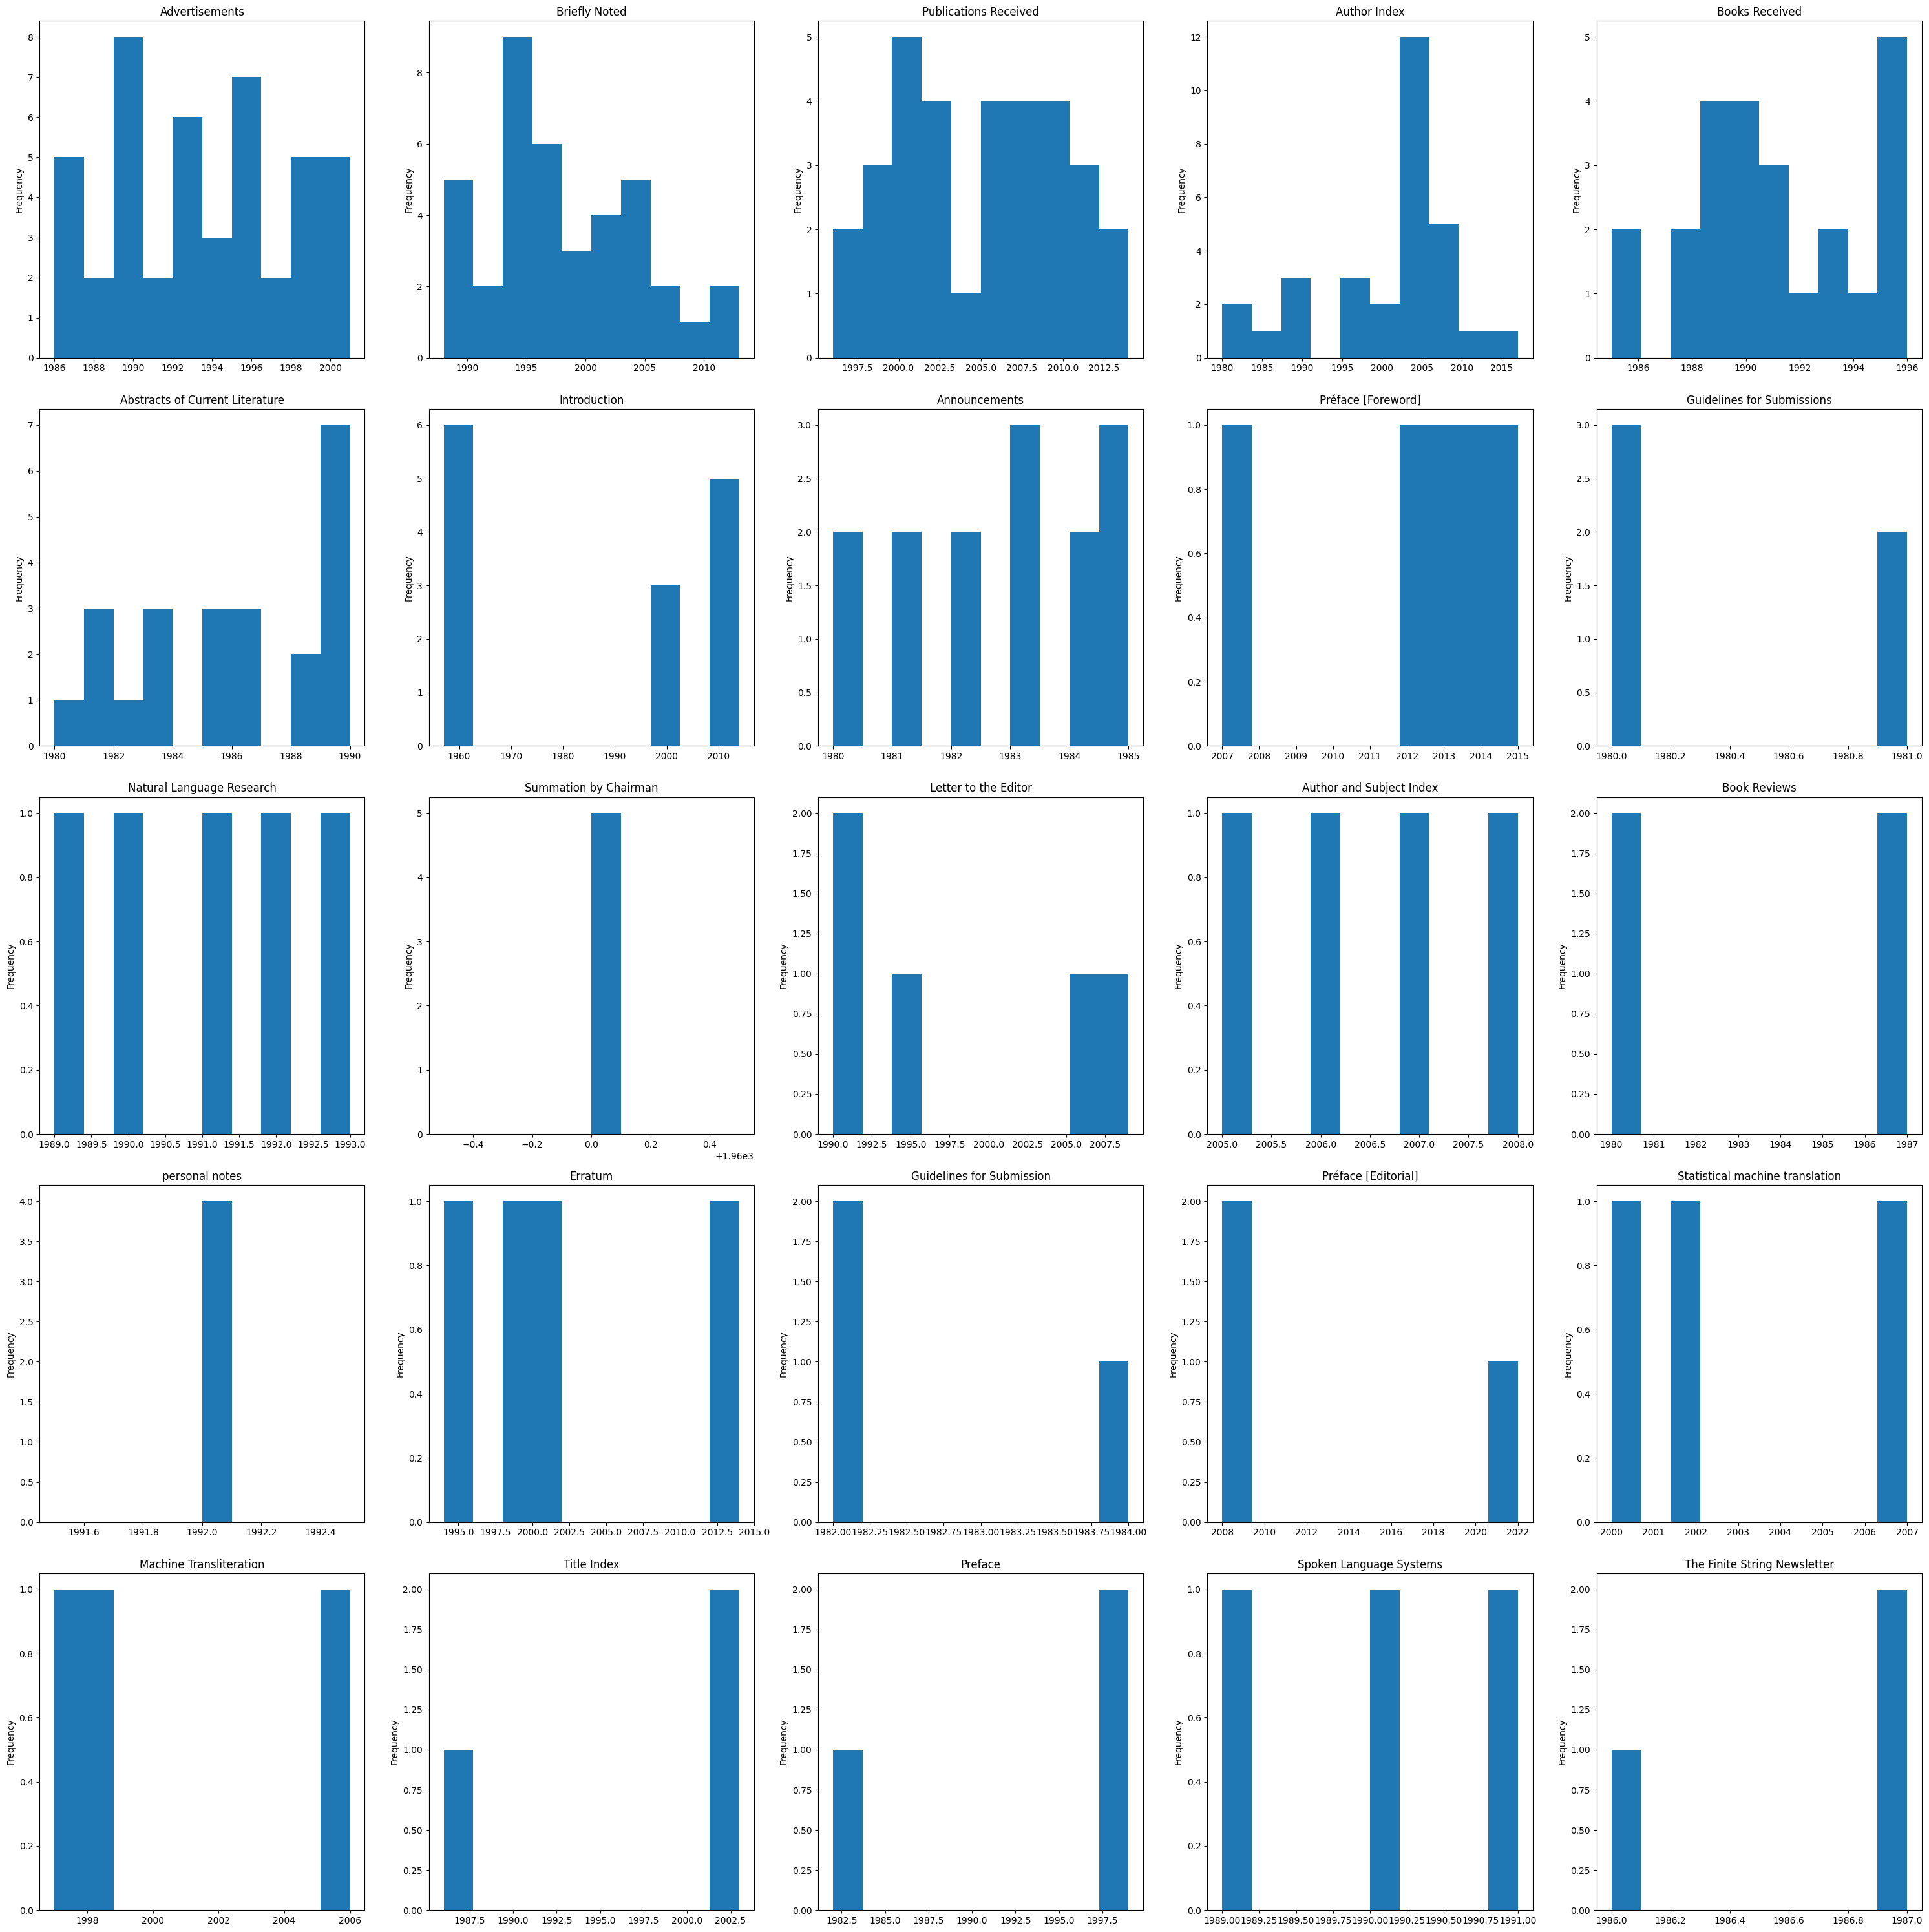

In [ ]:
import matplotlib.pyplot as plt


fig, axes = plt.subplots(5, 5, figsize=[30, 30])

for i, index in enumerate(df.iloc[:, 1].value_counts().index[:25]):
    row = i // 5
    col = i % 5

    df.loc[df['title'] == index, 'year'].plot.hist(ax=axes[row, col])
    axes[row, col].set_title(index)

plt.tight_layout()
plt.show()



In [ ]:
no_of_top_titles = 40
commonest_titles = pd.concat([df[df['title'] == df.iloc[:, 1].value_counts().index[:no_of_top_titles][i]] for i in range (no_of_top_titles)])

In [ ]:
commonest_titles

,ENTRYTYPE,title,year,publisher,abstract,no_of_editors,s,edit_author,extracted_year,first_extracted_year
1129,article,Advertisements,1993,MIT Press,None,0,0,None,0,0
1331,article,Advertisements,1988,None,None,0,0,None,0,0
1364,article,Advertisements,1998,MIT Press,None,0,0,None,0,0
2052,article,Advertisements,1999,MIT Press,None,0,0,None,0,0
3847,article,Advertisements,1992,None,None,0,0,None,0,0
...,...,...,...,...,...,...,...,...,...,...
9088,article,Errata,2006,None,None,0,0,None,0,0
27071,article,Books Recieved,1987,None,None,0,0,None,0,0
37280,article,Books Recieved,1988,None,None,0,0,None,0,0
10211,inproceedings,Presentation,2006,Association for Machine Translation in the Ame...,None,0,1,"[Carbonell, Jaime]",0,0


In [ ]:

missing_ratio = commonest_titles.groupby('title')['edit_author'].apply(lambda x: x.isnull().mean())
full_missing = missing_ratio[missing_ratio > 0.75]
print(full_missing)


title
Abstracts of Current Literature    1.0
Advertisements                     1.0
Announcements                      1.0
Author Index                       1.0
Author and Subject Index           1.0
Books Received                     1.0
Books Recieved                     1.0
Briefly Noted                      1.0
Briefly Noted: Briefly Noted       1.0
Errata                             1.0
Erratum                            1.0
Guidelines For Submissions         1.0
Guidelines for Submission          1.0
Guidelines for Submissions         1.0
List of participants               1.0
Publications Received              1.0
Title Index                        1.0
personal notes                     1.0
Name: edit_author, dtype: float64


In [ ]:
# drop the titles with neither editors or authors
to_be_dropped = df['title'].isin(full_missing.index)

In [ ]:
df[to_be_dropped]['abstract'].notnull().sum() # all of them have empty abstracts

0

In [ ]:
df = df[~to_be_dropped] # dropped

### Year Distribution

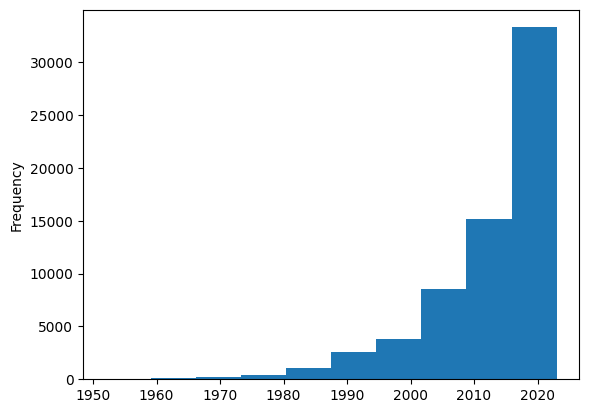

In [ ]:
# Explore year
df['year'].plot.hist()
plt.show() # see distribution of year

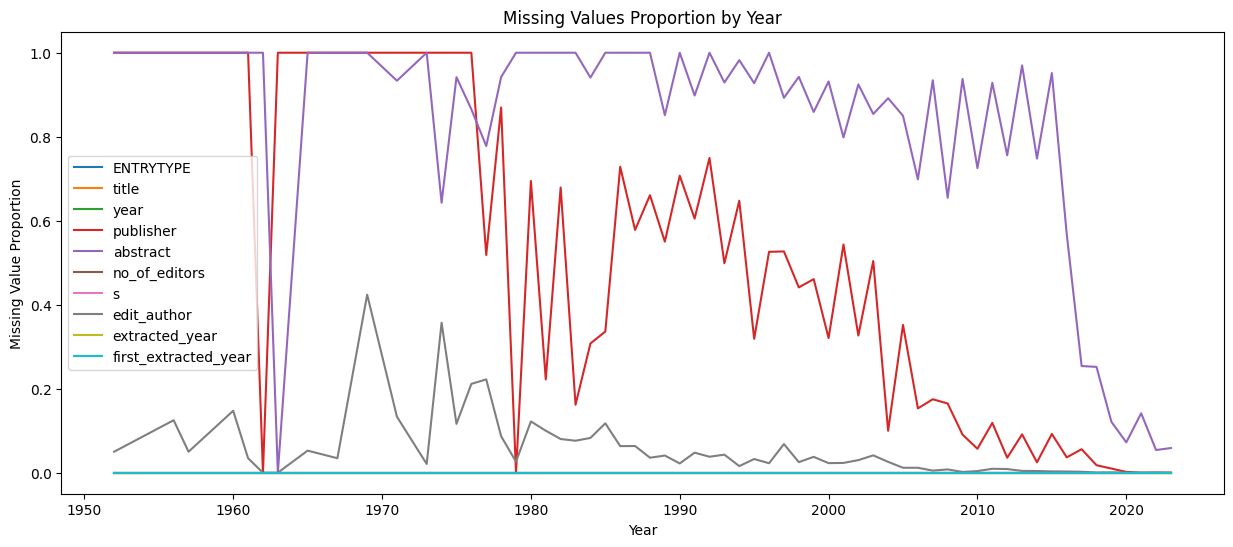

In [ ]:

missing_per_year = df.groupby('year').apply(lambda x: x.isnull().mean())

import matplotlib.pyplot as plt
plt.figure(figsize=(15, 6))
for column in missing_per_year.columns:
    plt.plot(missing_per_year.index, missing_per_year[column], label=column)
plt.xlabel('Year')
plt.ylabel('Missing Value Proportion')
plt.title('Missing Values Proportion by Year')
plt.legend()
plt.show()


<Axes: ylabel='year'>

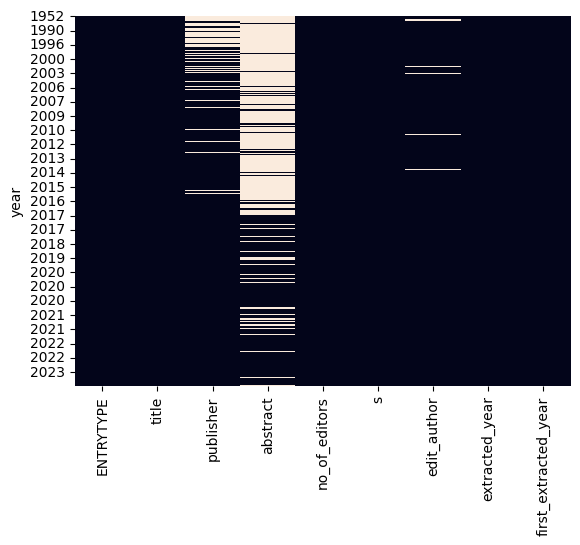

In [ ]:
sns.heatmap(df.copy().sort_values(by = 'year').set_index('year').isnull(), cbar=False)
# There is a clear pattern: earlier publications are likelier to have missing publishers and abstracts.

## Explore publisher

It has been resolved that articles are likelier to lack publishers, and early contributions are likelier to miss them too.

In [ ]:
no_pub = len(df['publisher'].unique())
print(f'There are {no_pub} publishers.')

There are 121 publishers.


<Axes: >

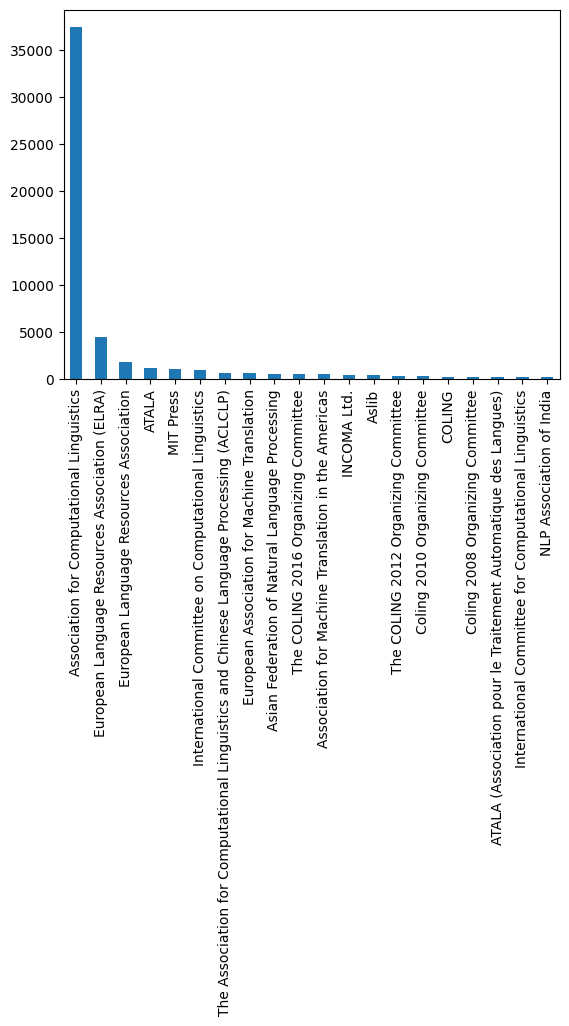

In [ ]:
df['publisher'].value_counts().head(20).plot.bar()

In [ ]:
df['publisher'].value_counts().head(20)

Association for Computational Linguistics                                                 37414
European Language Resources Association (ELRA)                                             4455
European Language Resources Association                                                    1843
ATALA                                                                                      1258
MIT Press                                                                                  1131
International Committee on Computational Linguistics                                        979
The Association for Computational Linguistics and Chinese Language Processing (ACLCLP)      679
European Association for Machine Translation                                                630
Asian Federation of Natural Language Processing                                             615
The COLING 2016 Organizing Committee                                                        561
Association for Machine Translation in t

Among 66000 data point, 57713 have publisher information, 53021 are from the biggest 20 journals, 37421 from ACL.


---

Very clearly certain publishers are more active during some time periods.

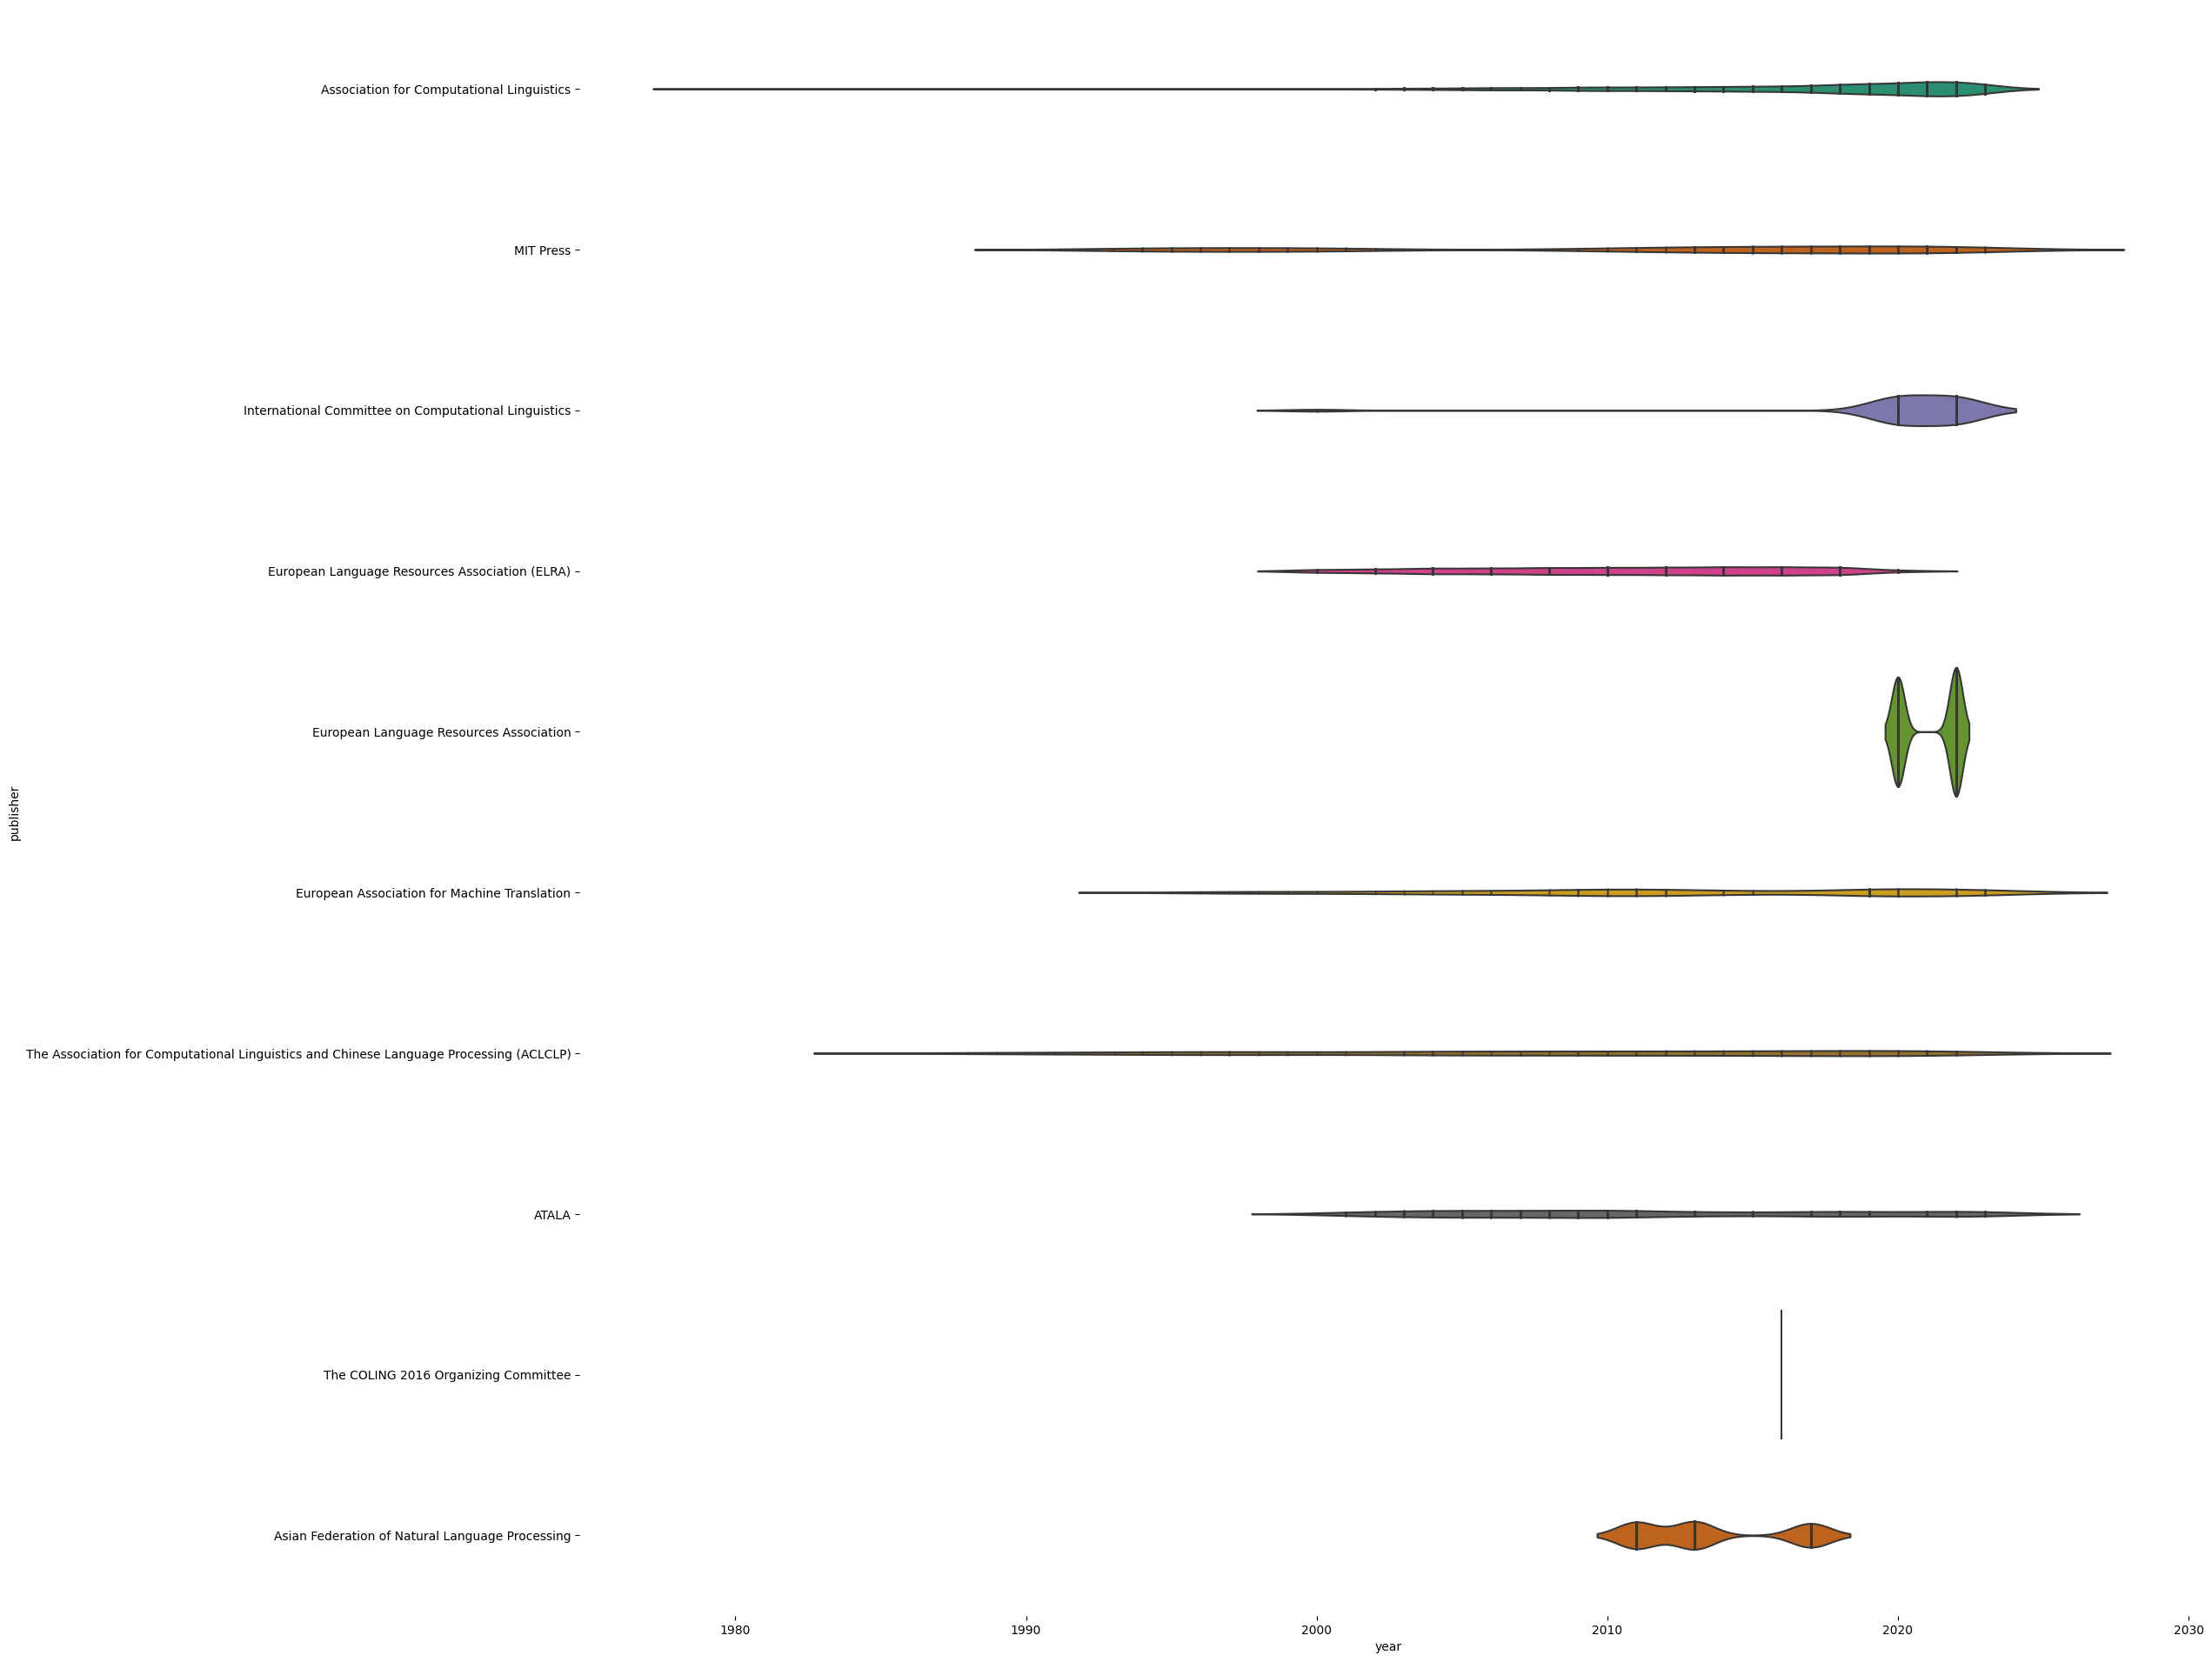

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

top_10_publishers = df['publisher'].value_counts().head(10).index


top_publishers_df = df[df['publisher'].isin(top_10_publishers)]


figsize = (24, 2.4 * len(top_publishers_df['publisher'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(data=top_publishers_df, x='year', y='publisher', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)
plt.show()


In [ ]:
df['extracted_pub_year'] = df['publisher'].str.extract(r'.*((19|20)\d{2})').iloc[:, 0]



In [ ]:
df['extracted_pub_year'] = df['extracted_pub_year'].fillna(df['extracted_year'])


In [ ]:
df

,ENTRYTYPE,title,year,publisher,abstract,no_of_editors,s,edit_author,extracted_year,first_extracted_year,extracted_pub_year
36,inproceedings,Paying Heed to Collocations,1996,None,None,0,2,"[Stone, Matthew, Doran, Christine]",0,0,0
58,inproceedings,Parsing as Deduction,1983,Association for Computational Linguistics,None,0,2,"[Pereira, Fernando C. N., Warren, David H. D.]",0,0,0
135,inproceedings,PJAIT Systems for the WMT 2016,2016,Association for Computational Linguistics,None,0,2,"[Wolk, Krzysztof, Marasek, Krzysztof]",2016,2016,2016
159,inproceedings,PET: Processing English Text,1982,None,None,0,1,"[Oppacher, F.]",0,0,0
179,inproceedings,Directed Replacement,1996,Association for Computational Linguistics,None,0,1,"[Karttunen, Lauri]",0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
65909,inproceedings,Optimizing the weighted sequence alignment alg...,2022,Association for Computational Linguistics,We present an optimized implementation of the ...,0,1,"[Janicki, Maciej]",0,0,0
65910,proceedings,Proceedings of the 25th Conference on Computat...,2021,Association for Computational Linguistics,None,2,0,"[Bisazza, Arianna, Abend, Omri]",0,0,0
65911,article,A Large-Scale Pseudoword-Based Evaluation Fram...,2014,MIT Press,None,0,2,"[Pilehvar, Mohammad Taher, Navigli, Roberto]",0,0,0
65912,inproceedings,CIST System for CL-SciSumm 2016 Shared Task,2016,None,None,0,7,"[Li, Lei, Mao, Liyuan, Zhang, Yazhao, Chi, Jun...",2016,2016,2016


In [ ]:
pub_with_years = df[df.copy().fillna('')['publisher'].str.contains(r'.*((19|20)\d{2})')]

<ipython-input-98-ddc255853737>:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  pub_with_years = df[df.copy().fillna('')['publisher'].str.contains(r'.*((19|20)\d{2})')]


In [ ]:
pub_without_years = df[~df.copy().fillna('')['publisher'].str.contains(r'.*((19|20)\d{2})')]

<ipython-input-99-96e665321ea1>:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  pub_without_years = df[~df.copy().fillna('')['publisher'].str.contains(r'.*((19|20)\d{2})')]


In [ ]:
pub_with_years

,ENTRYTYPE,title,year,publisher,abstract,no_of_editors,s,edit_author,extracted_year,first_extracted_year,extracted_pub_year
3035,inproceedings,Paraphrases and Applications,2010,Coling 2010 Organizing Committee,None,0,2,"[Zhao, Shiqi, Wang, Haifeng]",0,0,2010
5382,inproceedings,A Toolchain for Grammarians,2008,Coling 2008 Organizing Committee,None,0,6,"[Guillaume, Bruno, Le Roux, Joseph, Marchand, ...",0,0,2008
7347,inproceedings,The 2008 MedSLT System,2008,Coling 2008 Organizing Committee,None,0,13,"[Rayner, Manny, Bouillon, Pierrette, Brotanek,...",2008,2008,2008
10359,inproceedings,Parallel Sentence Compression,2016,The COLING 2016 Organizing Committee,Sentence compression is a way to perform text ...,0,2,"[Ive, Julia, Yvon, François]",0,0,2016
13539,inproceedings,Using TEI for textbook research,2016,The COLING 2016 Organizing Committee,The following paper describes the first steps ...,0,3,"[Stahn, Lena-Luise, Hennicke, Steffen, De Luca...",0,0,2016
...,...,...,...,...,...,...,...,...,...,...,...
65716,proceedings,Proceedings of the 3rd Workshop on Natural Lan...,2016,The COLING 2016 Organizing Committee,None,4,0,"[Chen, Hsin-Hsi, Tseng, Yuen-Hsien, Ng, Vincen...",2016,2016,2016
65767,inproceedings,Bridging the Gap between Intrinsic and Perceiv...,2012,The COLING 2012 Organizing Committee,None,0,3,"[He, Jing, Duboue, Pablo, Nie, Jian-Yun]",0,0,2012
65831,inproceedings,Semantic Parsing for High-Precision Semantic R...,2008,Coling 2008 Organizing Committee,None,0,2,"[Merlo, Paola, Musillo, Gabriele]",0,0,2008
65882,inproceedings,Negative Feedback: The Forsaken Nature Availab...,2010,Coling 2010 Organizing Committee,None,0,5,"[Hong, Yu, Cai, Qing-qing, Hua, Song, Yao, Jia...",0,0,2010


In [ ]:
pub_with_years[pub_with_years['extracted_pub_year'] != pub_with_years['year']]

,ENTRYTYPE,title,year,publisher,abstract,no_of_editors,s,edit_author,extracted_year,first_extracted_year,extracted_pub_year


## Explore editor authors

In [ ]:
df[df.copy()['edit_author'].fillna(value= '').str.join(', ').str.contains('/')]

,ENTRYTYPE,title,year,publisher,abstract,no_of_editors,s,edit_author,extracted_year,first_extracted_year
11835,inproceedings,Architecture Overview,1996,Association for Computational Linguistics,None,0,1,[TIPSTER SE/CM],0,0
30434,inproceedings,List of Available Documents,1996,Association for Computational Linguistics,None,0,1,[TIPSTER SE/CM],0,0
4800,inproceedings,Speech Recognition for Tigrinya language Using...,2019,Association for Computational Linguistics,This work presents a speech recognition model ...,0,2,"[Abera, Hafte, H/mariam, Sebsibe]",0,0
7638,inproceedings,Design of a Tigrinya Language Speech Corpus fo...,2018,Association for Computational Linguistics,"In this paper, we describe the first Tigrinya ...",0,2,"[Abera, Hafte, H/Mariam, Sebsibe]",0,0
17968,inproceedings,How to Get Information About TIPSTER,1996,Association for Computational Linguistics,None,0,1,[TIPSTER SE/CM],0,0
23313,inproceedings,Overview and Accomplishments the SE/CM Perspec...,1996,Association for Computational Linguistics,None,0,1,[TIPSTER SE/CM],0,0
32368,inproceedings,The Architecture Demonstration System,1996,Association for Computational Linguistics,None,0,1,[TIPSTER SE/CM],0,0


In [ ]:
df[df.copy()['edit_author'].fillna(value= '').str.join(', ').str.contains('@')]

,ENTRYTYPE,title,year,publisher,abstract,no_of_editors,s,edit_author,extracted_year,first_extracted_year
2512,inproceedings,Seeing the wood for the trees: a contrastive r...,2022,Association for Computational Linguistics,Given a context knowledge base (KB) and a corr...,0,6,"[Jpliu@wtu.edu.cn, Jpliu@wtu.edu.cn, Mei, Shij...",0,0
19935,inproceedings,A New Concept of Knowledge based Question Answ...,2022,Association for Computational Linguistics,Knowledge based question answering (KBQA) is a...,0,3,"[Wang, Yu, V.srinivasan@samsung.com, V.sriniva...",0,0
48753,inproceedings,Follow the Knowledge: Structural Biases and Ar...,2023,Association for Computational Linguistics,Crowd-sourcing has been one of the primary way...,0,4,"[Lotfi, Ehsan, De Bruyn, Maxime, Jeska.buhmann...",0,0


<Axes: xlabel='year', ylabel='no_of_editors'>

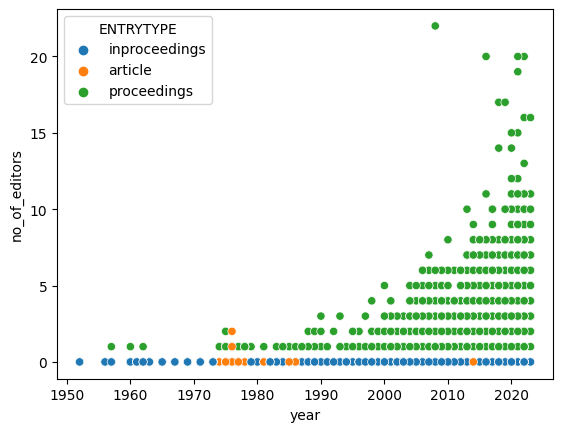

In [ ]:
sns.scatterplot(df[['ENTRYTYPE', 'year', 'no_of_editors']], x = 'year', y = 'no_of_editors', hue = 'ENTRYTYPE')

In [ ]:
sns.scatterplot(df[['ENTRYTYPE', 'year', 'no_of_authors']], x = 'year', y = 'no_of_authors', hue = 'ENTRYTYPE')

KeyError: ignored

## Explore abstracts
Very clear that proceedings do not have abstracts, so their missing abstarcts are of a different nature, a point to pay attention to when filling NAs. Or can we train a separate thing for them?


Earlier articles tend to miss abstracts.

In [ ]:
df.groupby('year')['abstract'].agg(lambda x: (x.isnull().sum()/len(x))*100).plot.bar(figsize = (20, 10), title= 'The percentage of articles whose titles are missing in each year')

In [ ]:
# extract length of abstracts
import re
def punctuation(t):
  return re.sub(r'[^\w\s]', '', t)
len(punctuation(df.loc[65909, 'abstract'].strip()).split())

In [ ]:
df['abstract_length'] = df['abstract'].fillna('').str.strip().apply(punctuation).str.split().apply(len)

In [ ]:
df[['abstract_length', 'ENTRYTYPE', 'year']]

In [ ]:
df.groupby('year')['abstract_length'].agg('mean').plot.bar(figsize = (20, 10))

In [ ]:
_df_18 = df[df['year'] == 1963]
_df_18

In [ ]:
new_df = df[df['abstract'].fillna('').str.strip().str.contains(r'\w[^-\s\w]\w')].head(100)
new_df['abstract']= new_df['abstract'].apply(punctuation)
new_df

## revisiting NAs

In [ ]:
df.isnull().sum()

In [ ]:

missing_per_year = df.groupby('year').apply(lambda x: x.isnull().mean())

import matplotlib.pyplot as plt
plt.figure(figsize=(15, 6))
for column in missing_per_year.columns:
    plt.plot(missing_per_year.index, missing_per_year[column], label=column)
plt.xlabel('Year')
plt.ylabel('Missing Value Proportion')
plt.title('Missing Values Proportion by Year')
plt.legend()
plt.show()


In [ ]:
sns.heatmap(df_set_by_year.loc[df_set_by_year['ENTRYTYPE'] == 'inproceedings',[  'publisher', 'edit_author', 'abstract']].isnull(), cbar=False)

In [ ]:
sns.heatmap(df_set_by_year.loc[df_set_by_year['ENTRYTYPE'] == 'article',[  'publisher', 'edit_author', 'abstract']].isnull(), cbar=False)

In [ ]:
sns.heatmap(df_set_by_year.loc[df_set_by_year['ENTRYTYPE'] == 'proceedings',[  'publisher', 'edit_author', 'abstract']].isnull(), cbar=False)

# Baseline
Mean baseline MAE: 7.806169120928178
Ridge regressor MAE: 5.783057913575414

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import Input, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TextVectorization, Embedding
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import L1, L2, L1L2
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
import json
datapath= '/content/drive/MyDrive/Colab Notebooks/ml_assign/train.json'
with open(datapath, 'r') as f:
  data = json.load(f)

In [ ]:
df = pd.DataFrame(data)

In [ ]:
X = df.drop(['year'], axis = 1)
y = df['year'].apply(int)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error

# Assuming X_train, y_train, X_test, y_test are already defined

# Feature transformation
featurizer = ColumnTransformer(
    transformers=[("title", CountVectorizer(), "title")],
    remainder='drop')
featurizer1 = ColumnTransformer(
    transformers=[("title", TfidfVectorizer(), "title")],
    remainder='drop')

# Initialize models
dummy = make_pipeline(featurizer, DummyRegressor(strategy='mean'))
dummy2 = make_pipeline(featurizer, DummyRegressor(strategy='median'))
ridge = make_pipeline(featurizer, Ridge())
ridge_tfidf = make_pipeline(featurizer1, Ridge())
# Fit models
dummy.fit(X_train, y_train)
dummy2.fit(X_train, y_train)
ridge.fit(X_train, y_train)
ridge_tfidf.fit(X_train, y_train)

# Evaluate models
dummy_mae = mean_absolute_error(y_test, dummy.predict(X_test))
dummy2_mae = mean_absolute_error(y_test, dummy2.predict(X_test))
ridge_mae = mean_absolute_error(y_test, ridge.predict(X_test))
ridge_tfidf_mae = mean_absolute_error(y_test, ridge_tfidf.predict(X_test))
print(f"Mean baseline MAE: {dummy_mae}")
print(f"Median baseline MAE: {dummy2_mae}")
print(f"Ridge regressor MAE: {ridge_mae}")
print(f'Ridge IFTDF regressor MAE: {ridge_tfidf_mae}"')


Mean baseline MAE: 7.805790808578574
Median baseline MAE: 7.4434668284789645
Ridge regressor MAE: 5.70971311954168
Ridge IFTDF regressor MAE: 5.346071683666794"


In [ ]:
y_pred = ridge_tfidf.predict(X_test)
print(f'mean of residuals: {np.sum(y_test - y_pred) / len(y_test)}')

mean of residuals: -0.04428423768091358


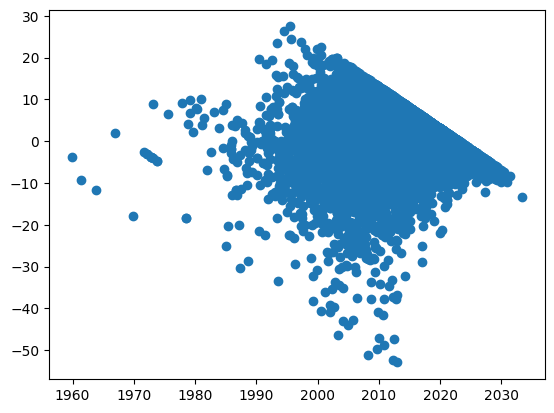

In [ ]:
residuals = y_test - y_pred
plt.scatter(y_test, residuals)
plt.show()